# **CSE4022: Natural Language Proccessing J Component (Slot:B2)**
## **Project Title:** Automatic Story Generation
### **Team Members:**
1.   Talatala Rahul Reddy  (19BCE1778)
2.   Pulimi Bhargava Reddy (19BCE1342)

#### In this notebook we have trained the Bi-directional LSTM Model on multiple short stories

### Importing Libraries & Downloading Dependecies

In [ ]:
#%tensorflow_version 2.x  #selects the tensorflow 2.0+ version
import tensorflow as tf
import string
import requests
import nltk
import bs4
import re
import nltk
nltk.download('punkt')
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Embedding, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Scraping the Short Stories Website http://www.classicshorts.com/ to train the above models

In [ ]:
#return bs4 object
def getPage(url,headers):
    res = requests.get(url, headers=headers)
    try:
        res.raise_for_status()
    except:
        pass
    pageHtml=bs4.BeautifulSoup(res.text,'html.parser')
    return pageHtml

#check if previous scrape already contained the given listing
def getStoryText(link):
    regex = re.compile(r'[\n\r\t]')
    headers = {'User-Agent': 'Mozilla/5.0'}
    pageHtml=getPage(link,headers)
    elems = pageHtml.find_all("div", class_="StoryPara")
    totalText = ""
    for e in elems:
        totalText += regex.sub(" ", e.text.strip())
    return totalText

# Returns an array of dcitionaries - turnip listings
def getListings():
    no_of_stories = 0
    badTitles = {'tlrm','fiddler','frog','ItalianMaster','luck'}
    #f = open("short_stories.txt", "a", encoding='utf-8')
    url = "http://www.classicshorts.com/bib.html"
    headers = {'User-Agent': 'Mozilla/5.0'}
    storyTexts = []
    rawText = ""
    pageHtml=getPage(url,headers)
    elems = pageHtml.find_all("div", class_="biolisting")
    for e in elems:
        currentUrl = "http://www.classicshorts.com/stories/"+e.attrs['onclick'][11:-2]+".html"
        if e.attrs['onclick'][11:-2] not in badTitles:
            pog = getStoryText(currentUrl)
            storyTexts.append(pog)
            no_of_stories = no_of_stories + 1
            #print("No of Stories:"+str(no_of_stories))
            rawText += pog
        if no_of_stories == 100:
            break
        
    #print("Len of story texts:"+str(len(storyTexts)))
    #print("No of stories:"+str(no_of_stories))
    #print(storyTexts)
    #f.write(rawText)
    #f.close()
    return rawText

In [ ]:
#fetching the short stories by scraping
stories = getListings()
stories = stories[81:]
len(stories)

1983654

### Sentence Tokenising the short-stories

In [ ]:
#performing sentence tokenisation
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(stories)
len(sentences)

20516

In [ ]:
#displays first 3 sentences
sentences[:3]

['My Dear Sir: I am happy to assure you that your anxiety is without reason.',
 'Flemming will be confined to the sofa for three or four weeks, and will have to be careful at first how he uses his leg.',
 'A fracture of this kind is always a tedious affair.']

### Tokenising the short stories and cleaning the data

In [ ]:
#cleaning the dataset
def clean_text(sentences):
    #creating tokens from the document
    tokens = []
    for sentence in sentences:
      tokens.extend(nltk.word_tokenize(sentence))
    punc = str.maketrans('','',string.punctuation)
    #this list will remove punctuations
    tokens = [ x.translate(punc) for x in tokens]
    #this list will remove special characters
    tokens = [ x for x in tokens if x.isalpha()]
    #this list converts all the words to lowercase
    tokens = [ x.lower() for x in tokens]
    return tokens

In [ ]:
tokens = clean_text(sentences)

In [ ]:
tokens[:10]

['my', 'dear', 'sir', 'i', 'am', 'happy', 'to', 'assure', 'you', 'that']

In [ ]:
len(tokens) #no of tokens in the 100 short stories

364182

In [ ]:
len(set(tokens)) #no of unique words in the 100 short stories

21957

### Generating sequence of tokens

In [ ]:
#creating the sequence of tokens
length = 50 + 1 #first 50 words as input and 1 as the output
lines = []

for i in range(length,len(tokens)):
    seq = tokens[i-length:i]
    line = ' '.join(seq)
    lines.append(line)
    if i > 110000: #we're only taking few tokens as input for the model
        break

In [ ]:
len(lines)

109951

In [ ]:
lines[:4]

['my dear sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately',
 'dear sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately the',
 'sir i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a tedious affair fortunately the bone',
 'i am happy to assure you that your anxiety is without reason flemming will be confined to the sofa for three or four weeks and will have to be careful at first how he uses his leg a fracture of this kind is always a ted

### Converting tokens to numerical values

In [ ]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(lines) 
#performing tokenisation on the seq of words (lines) and these seq of words are embedded as integers basically word embedding
#every unique token(word) is given an integer as ML model only works on numerical values
sequences = tokenizer.texts_to_sequences(lines)

In [ ]:
tokenizer.word_index 

{'the': 1,
 'and': 2,
 'of': 3,
 'a': 4,
 'to': 5,
 'he': 6,
 'in': 7,
 'was': 8,
 'i': 9,
 'his': 10,
 'it': 11,
 'that': 12,
 'had': 13,
 'with': 14,
 'you': 15,
 'she': 16,
 'on': 17,
 'at': 18,
 'her': 19,
 'as': 20,
 's': 21,
 'for': 22,
 'him': 23,
 'not': 24,
 'but': 25,
 'is': 26,
 'they': 27,
 'from': 28,
 'were': 29,
 'my': 30,
 'said': 31,
 'there': 32,
 'be': 33,
 'all': 34,
 'by': 35,
 'one': 36,
 'have': 37,
 'me': 38,
 'would': 39,
 'nt': 40,
 'an': 41,
 'no': 42,
 'out': 43,
 'up': 44,
 'this': 45,
 'which': 46,
 'what': 47,
 'when': 48,
 'man': 49,
 'we': 50,
 'so': 51,
 'do': 52,
 'them': 53,
 'then': 54,
 'into': 55,
 'or': 56,
 'their': 57,
 'could': 58,
 'now': 59,
 'if': 60,
 'been': 61,
 'like': 62,
 'are': 63,
 'did': 64,
 'about': 65,
 'down': 66,
 'who': 67,
 'your': 68,
 'some': 69,
 'little': 70,
 'over': 71,
 'only': 72,
 'will': 73,
 'eyes': 74,
 'time': 75,
 'more': 76,
 'old': 77,
 'very': 78,
 'back': 79,
 'made': 80,
 'come': 81,
 'again': 82,
 'know':

In [ ]:
sequences = np.array(sequences)

In [ ]:
sequences[:2]
#it is a 2d array
#rows represent the line of the short stories
#column represent the words (there are 51 cols)

array([[   30,   309,   846,     9,    97,   567,     5,  1890,    15,
           12,    68,  3705,    26,   132,   524,   702,    73,    33,
        11636,     5,     1,  2266,    22,   188,    56,   300,   969,
            2,    73,    37,     5,    33,  5505,    18,   102,   103,
            6, 11633,    10,   371,     4, 11630,     3,    45,   318,
           26,   177,     4,  5504,  3703,  2805],
       [  309,   846,     9,    97,   567,     5,  1890,    15,    12,
           68,  3705,    26,   132,   524,   702,    73,    33, 11636,
            5,     1,  2266,    22,   188,    56,   300,   969,     2,
           73,    37,     5,    33,  5505,    18,   102,   103,     6,
        11633,    10,   371,     4, 11630,     3,    45,   318,    26,
          177,     4,  5504,  3703,  2805,     1]])

In [ ]:
sequences.shape #51 cols are words where we take first 50 cols(words) as x and last col(word) as y

(109951, 51)

### Preparing data to that has to fed into the model

In [ ]:
#first 50 tokens(words) are x and last tokens is y
X,y = sequences[:,:-1] , sequences[:,-1]
#sequences[:,-1] selects only the last col
#sequences[:,:-1] selects all cols except the last col

In [ ]:
X[:2]

array([[   30,   309,   846,     9,    97,   567,     5,  1890,    15,
           12,    68,  3705,    26,   132,   524,   702,    73,    33,
        11636,     5,     1,  2266,    22,   188,    56,   300,   969,
            2,    73,    37,     5,    33,  5505,    18,   102,   103,
            6, 11633,    10,   371,     4, 11630,     3,    45,   318,
           26,   177,     4,  5504,  3703],
       [  309,   846,     9,    97,   567,     5,  1890,    15,    12,
           68,  3705,    26,   132,   524,   702,    73,    33, 11636,
            5,     1,  2266,    22,   188,    56,   300,   969,     2,
           73,    37,     5,    33,  5505,    18,   102,   103,     6,
        11633,    10,   371,     4, 11630,     3,    45,   318,    26,
          177,     4,  5504,  3703,  2805]])

In [ ]:
y[:2]

array([2805,    1])

In [ ]:
vocabulary_size = len(tokenizer.word_index) + 1 #1 as it's stating from 1 (that word_index is from 1)
vocabulary_size

11638

In [ ]:
y = to_categorical(y,num_classes=vocabulary_size)
# a numpy array/vector which has integers that represent different categories is converted into a numpy array/matrix 
#which has binary values and has columns equal to the number of categories in the data.
#X.shape[1] is 50
seq_length = X.shape[1]

### Creating a function to generate stories from a given seed text

In [ ]:
def generate_story(model,tokenizer,text_seq_len,seed_text,n_words):
  text = []
  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    #the model expects the input(sentences) to be of same length hence we use the pad_sequences
    #pre it adds 0 before the sentence
    encoded = pad_sequences([encoded],maxlen=text_seq_len,padding='pre')

    pred = model.predict(encoded) 
    y_pred = np.argmax(pred,axis=1)
    predicted_word = ''
    for word,index in tokenizer.word_index.items():
      if index == y_pred:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word
    text.append(predicted_word)
  return ' '.join(text)

### Training the Bi-directional LSTM Model

In [ ]:
bi_di_lstm = Sequential()
#input layer
bi_di_lstm.add(Embedding(vocabulary_size,50,input_length=seq_length))
#hidden layer 1 (LSTM layer)
bi_di_lstm.add(Bidirectional(LSTM(100,return_sequences=True)))
bi_di_lstm.add(Dropout(0.2))
#hidden layer 2 (LSTM layer)
bi_di_lstm.add(LSTM(120))
#hidden layer 3 (dense layer)
bi_di_lstm.add(Dense(140,activation='relu'))
#output layer
bi_di_lstm.add(Dense(vocabulary_size,activation='softmax'))#units=vocab size bcoz we want probability for each predicted word

In [ ]:
bi_di_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            581900    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 120)               154080    
                                                                 
 dense (Dense)               (None, 140)               16940     
                                                                 
 dense_1 (Dense)             (None, 11638)             1640958   
                                                        

In [ ]:
bi_di_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
bidi_lstm_history = bi_di_lstm.fit(X,y,batch_size=256,epochs=150)

Epoch 1/150
430/430 [==============================] - 41s 72ms/step - loss: 6.8940 - accuracy: 0.0665
Epoch 2/150
430/430 [==============================] - 31s 72ms/step - loss: 6.3632 - accuracy: 0.0833
Epoch 3/150
430/430 [==============================] - 31s 71ms/step - loss: 6.0573 - accuracy: 0.0997
Epoch 4/150
430/430 [==============================] - 31s 71ms/step - loss: 5.8654 - accuracy: 0.1116
Epoch 5/150
430/430 [==============================] - 31s 71ms/step - loss: 5.7260 - accuracy: 0.1184
Epoch 6/150
430/430 [==============================] - 31s 71ms/step - loss: 5.6191 - accuracy: 0.1233
Epoch 7/150
430/430 [==============================] - 31s 71ms/step - loss: 5.5263 - accuracy: 0.1274
Epoch 8/150
430/430 [==============================] - 31s 71ms/step - loss: 5.4450 - accuracy: 0.1314
Epoch 9/150
430/430 [==============================] - 31s 72ms/step - loss: 5.3666 - accuracy: 0.1359
Epoch 10/150
430/430 [==============================] - 31s 72ms/step - l

In [ ]:
bi_di_lstm.save('./Bi_di_LSTM.h5')

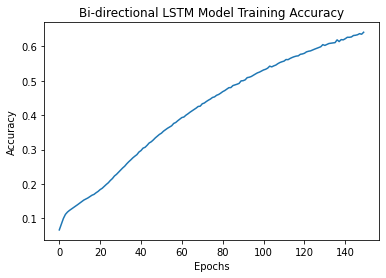

In [ ]:
import matplotlib.pyplot as plt
epochs = range(len(bidi_lstm_history.history['accuracy']))
plt.plot(epochs,bidi_lstm_history.history['accuracy'])
plt.title("Bi-directional LSTM Model Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.show()

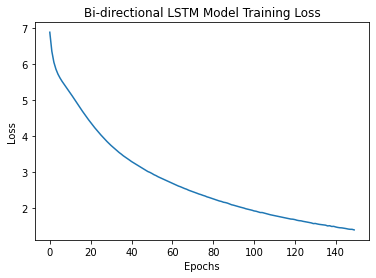

In [ ]:
plt.plot(epochs,bidi_lstm_history.history['loss'])
plt.title("Bi-directional LSTM Model Training Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.show()

### Generating Stories from Bi-directional LSTM Model

In [ ]:
seed_text = "The country was in chaos but"
generate_story(bi_di_lstm, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'the basin and the breathing observed in lace and pearls was struggling to flagstone to flagstone every sidewalk them and as if he dared not go to words the principal went to her head and the lights he could see that the polar regions in a june thaw it was'

In [ ]:
seed_text = "I walked out of the store dissatisfied and it"
generate_story(bi_di_lstm, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'looks into the stump from a chameleonlike aptitude at impressions and swimming and his room the crystal the silver the chinathey were eating borsch the rich red soup with whipped cream so dear to russian palates half apologetically general zaroff i am afraid senator you had a good slim gentleman'

In [ ]:
seed_text = "The lady was known as a soothsayer - a psychic of sorts. The rubbing of her crystal ball was finalized as she completed her prophecy. Her hands were wrinkled and dirty, a strange companion to the polish of the ball she held in her hands."
generate_story(bi_di_lstm, tokenizer, seq_length, seed_text, 50) #generate next 50 words

'paul sank into the ooze he tried to manhood with children that he had a strange roseate faint green delicacy in the hedge she were of snuff he was either a cupboard of wild file and ease with their arrival about him in the soapy water and he distinctly heard'

In [ ]:
seed_text = "Little Chandler's thoughts ever since lunch-time had been of his meeting with Gallaher, of Gallaher's invitation, and of the great city London where Gallaher lived. He was called Little Chandler because"
generate_story(bi_di_lstm, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'questioned the crackling of the sea among fancy the blond fur of his overcoat his drivers of the mother better counsels prevailed and a fragment of variegated quartz a row of mud shacks at the end of the wharf a straight dollars under the lodge and the yellow moments of the rounding sun some yacht the room touched and every time he wore a towel and brandy and food of my bedroom and they could watch him approach and keeping it back of the supper and the greater walk of the pantry and deserted she had waked from a cold'

In [ ]:
seed_text = "On the morning of the fifth of September, in uniform, his revolver on the table, the colonel addressed his soliders and"
generate_story(bi_di_lstm, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'a matter which the passing of a wild gallop and a row of mud shacks into the direction of the toothless old woman when the giant his eyes descended they were smiling over the candlebox half from his brother s brain it prevented him half holding him to his white shadow when it was uncomfortably at the back of the situation or trees the wind shot their noses and looked into the gate and ran into the direction of the exit gate the hired car was still unfortunately before the dripping spiggots her human doubt going along and down at'

In [ ]:
seed_text = "On Christmas Eve around 1978, when I was a young boy, after having the traditional pastry and cookies and after having sung around the fire, I, with my sister, my mother and my aunts, and Emma Jackman and her son, got into Emma Jackman's car and then later"
generate_story(bi_di_lstm, tokenizer, seq_length, seed_text, 100) #generate next 100 words

'then composing me to dodge a basin and so as they accepted to know this is now admiring the seashell way striding up on the beach stumpy was not a quarter of her thank them it may be no longer they wo nt give him a weak and vigor do not know that i ve got a surprise for you i do nt know why i bet you to humour it i want to correct you carry you will make it up and i am as caliban among the freezer oh i do nt know you before you d be'